# Двухмерный случай

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
G = 6.67e-11
delta_t = 100

In [3]:
class CosmicBody:
    def __init__(self, mass: float, vec_v: np.ndarray, vec_P: np.ndarray, radius=0.0):
        self.mass = mass
        self.vec_v = vec_v
        self.vec_P = vec_P
        self.delta_V = np.array([0., 0.])
        self.radius = radius

    def destroy(self):
        self.mass = 0.0
        
    def move(self): #двигает объект
        if self.is_destroyed(): #проверка что объект существует
            return
        self.vec_v += self.delta_V #изменение скорости
        self.vec_P += self.vec_v * delta_t + self.delta_V * delta_t ** 2 / 2 #изменение координаты
        
    def is_destroyed(self): #проверка что объект существует
        return self.mass == 0.0

    def gravitate(self, bodys: list): #вычисляет действие тел на объект
        #проверка что ничего не пустое
        if self.is_destroyed():
            return
        if len(bodys) == 0:
            return
        #вычисление расстояний до других тел
        r = np.array([body.vec_P - self.vec_P for body in bodys])
        r_norm = np.sqrt(np.sum(r ** 2, axis=1))
        
        #проверка на столкновение
        is_destroyed = False
        for i, elem in enumerate(r_norm):
            if elem < self.radius + bodys[i].radius:
                self.destroy()
                bodys[i].destroy()
                is_destroyed = True
        if is_destroyed:
            return
        
        #вычисление прибавки к скорости
        masses = np.array([body.mass for body in bodys])
        self.delta_V = G * delta_t * np.sum(r.T * (masses / (r_norm ** 3)), axis=1)

    def trajectory(self, bodys: list): #вычисление траекторий
        if (self.is_destroyed()):
            return "body is destroyed"
        E = ((np.linalg.norm(self.vec_v)) ** 2) / 2
        for body in bodys:
            E = E - G * body.mass / np.linalg.norm(body.vec_P - self.vec_P)
        if (E < -1e-6):
            return "ellipse"
        if (E > 1e-6):
            return "hyperbole"
        return "parabola"

class Star(CosmicBody): 
    def __init__(self, mass, radius=0.0):
        super().__init__(mass, np.array([0., 0.]), np.array([0., 0.]), radius)

In [4]:
class World: #главный класс
    def __init__(self, bodys):
        self.bodys = []
        self.active_trajectories = []
        self.destroyed_trajectories = []
        for body in bodys:
            self.add_body(body)

    def step(self): #один шаг класса
        #осуществляем взаимодействие
        for i in range(len(self.bodys)):
            self.bodys[i].gravitate(self.bodys[:i] + self.bodys[i+1:])
        
        destroyed = {} #уничтоженные тела
        destroyed_trajectories = {} #уничтоженные траектории
        #передвижение тел
        for i, b in enumerate(self.bodys):
            b.move()
            if b.is_destroyed(): #проверка что тело уничтожено
                #добавляется в соответствующие списки
                destroyed[i] = b
                destroyed_trajectories[i] = self.active_trajectories[i]
                self.destroyed_trajectories.append(self.active_trajectories[i])
            else:
                self.active_trajectories[i].append(b.vec_P.copy())
        for i, b in destroyed.items(): #удаление несуществующих тел
            self.bodys.remove(b)
            self.active_trajectories.remove(destroyed_trajectories[i])

    def add_body(self, body): #добавление тел
        self.bodys.append(body)
        self.active_trajectories.append([body.vec_P.copy()])
  
    def bodys_count(self):
        return len(self.bodys)
    
    def plot_world(self): #вывод всех траекторий
        for trajectory in self.active_trajectories + self.destroyed_trajectories:
            x_values = [item[0] for item in trajectory]
            y_values = [item[1] for item in trajectory]
            plt.scatter(x_values, y_values)

In [5]:
def test_two_fishes(): #тест на столкновение
    times = np.arange(0, 100 * 24 * 36)
    varvara = Star(1.9e30)
    fish1 = CosmicBody(3.33e23, np.array([29800. / np.sqrt(2), -29800. / np.sqrt(2)]), np.array([146e9 / np.sqrt(2), 146e9 / np.sqrt(2)]), 7e6)
    fish2 = CosmicBody(3.33e23, np.array([29800. / np.sqrt(2), 29800. / np.sqrt(2)]), np.array([146e9 / np.sqrt(2), -(146e9 / np.sqrt(2))]), 7e6)
    world = World([varvara, fish1, fish2])

    for time in times:
        world.step()
    world.plot_world()
    plt.show()
    
    assert world.bodys_count() == 1

In [6]:
def test_one_fish(): #тест планеты Земля
    times = np.arange(0, 365.25 * 24 * 36)
    varvara = Star(1.9e30)
    fish = CosmicBody(3.33e23, np.array([29800. / np.sqrt(2), -29800. / np.sqrt(2)]), np.array([146e9 / np.sqrt(2), 146e9 / np.sqrt(2)]), 7e6)
    world = World([varvara, fish])
    
    for time in times:
        world.step()
    world.plot_world()
    plt.show()
    
    assert world.bodys_count() == 2

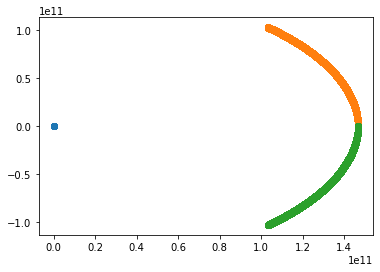

In [7]:
test_two_fishes()

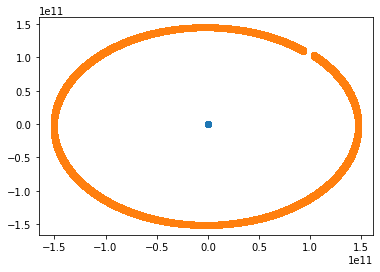

In [8]:
test_one_fish()

In [9]:
def test_trajectory(): #тест на определение траекторий
    times = np.arange(0, 50 * 24 * 36)
    varvara = Star(1.9e30)
    fish = CosmicBody(3.33e23, np.array([29800. / np.sqrt(2), -29800. / np.sqrt(2)]), np.array([146e9 / np.sqrt(2), 146e9 / np.sqrt(2)]), 7e6)
    assert fish.trajectory([varvara]) == "ellipse"
    fish1 = CosmicBody(3.33e23, np.array([-29800., -29800.]), np.array([146e9, 146e9]), 7e6)
    assert fish1.trajectory([varvara]) == "hyperbole"
    fish2 = CosmicBody(3.33e23, np.array([np.sqrt(1736027397.260274), 0]), np.array([146e9, 0]), 7e6)
    assert fish2.trajectory([varvara]) == "parabola"

In [10]:
test_trajectory()

# Трехмерный случай
## copy-paste

In [11]:
class CosmicBody3D:
    def __init__(self, mass: float, vec_v: np.ndarray, vec_P: np.ndarray, radius=0.0):
        self.mass = mass
        self.vec_v = vec_v
        self.vec_P = vec_P
        self.delta_V = np.array([0., 0., 0.])
        self.radius = radius

    def destroy(self):
        self.mass = 0.0
        
    def move(self):
        if self.is_destroyed():
            return
        self.vec_v += self.delta_V
        self.vec_P += self.vec_v * delta_t + self.delta_V * delta_t ** 2 / 2
        
    def is_destroyed(self):
        return self.mass == 0.0

    def gravitate(self, bodys: list):
        if self.is_destroyed():
            return
        if len(bodys) == 0:
            return
        
        r = np.array([body.vec_P - self.vec_P for body in bodys])
        r_norm = np.sqrt(np.sum(r ** 2, axis=1))
        
        is_destroyed = False
        for i, elem in enumerate(r_norm):
            if elem < self.radius + bodys[i].radius:
                self.destroy()
                bodys[i].destroy()
                is_destroyed = True
        if is_destroyed:
            return
        
        masses = np.array([body.mass for body in bodys])
        self.delta_V = G * delta_t * np.sum(r.T * (masses / (r_norm ** 3)), axis=1)

    def trajectory(self, bodys: list):
        if (self.is_destroyed()):
            return "body is destroyed"
        E = ((np.linalg.norm(self.vec_v)) ** 2) / 2
        for body in bodys:
            E = E - G * body.mass / np.linalg.norm(body.vec_P - self.vec_P)
        if (E < -1e-6):
            return "ellipse"
        if (E > 1e-6):
            return "hyperbole"
        return "parabola"

class Star3D(CosmicBody):
    def __init__(self, mass, radius=0.0):
        super().__init__(mass, np.array([0., 0., 0.]), np.array([0., 0., 0.]), radius)

# класс world изменим так, чтобы выводил анимацию

In [12]:
class World3D:
    def __init__(self, bodys, draw_interval=10000):
        #сразу создаем картинку
        self.fig = plt.figure(figsize=(12, 12))
        self.fig.show()
        self.fig.canvas.draw()
        self.ax = self.fig.add_subplot(projection='3d')
        self.iterations = 0
        self.draw_interval = draw_interval
        
        self.bodys = []
        self.active_trajectories = []
        self.destroyed_trajectories = []
        for body in bodys:
            self.add_body(body)

    #такие же функции как в 2d
    def step(self):
        for i in range(len(self.bodys)):
            self.bodys[i].gravitate(self.bodys[:i] + self.bodys[i+1:])
            
        destroyed = {}
        destroyed_trajectories = {}
        for i, b in enumerate(self.bodys):
            b.move()
            if b.is_destroyed():
                destroyed[i] = b
                destroyed_trajectories[i] = self.active_trajectories[i]
                self.destroyed_trajectories.append(self.active_trajectories[i])
            else:
                self.active_trajectories[i].append(b.vec_P.copy())
        for i, b in destroyed.items():
            self.bodys.remove(b)
            self.active_trajectories.remove(destroyed_trajectories[i])

    def add_body(self, body):
        self.bodys.append(body)
        self.active_trajectories.append([body.vec_P])
  
    def bodys_count(self):
        return len(self.bodys)
    
    def plot_world(self): #рисование анимации
        self.iterations += 1
        #будем рисовать не каждую итерацию, а каждые 10000, чтобы было быстрее
        if self.iterations == self.draw_interval:
            self.ax.clear()
            self.iterations = 0
            for trajectory in self.active_trajectories + self.destroyed_trajectories:
                x_values = [item[0] for item in trajectory]
                y_values = [item[1] for item in trajectory]
                z_values = [item[2] for item in trajectory]
                self.ax.scatter(x_values, y_values, z_values)
            self.fig.canvas.draw()

## Похожие тесты

In [13]:
def test_two_fishes3D():
    times = np.arange(0, 100 * 24 * 36)
    varvara = Star3D(1.9e30)
    fish1 = CosmicBody3D(3.33e23, np.array([29800. / np.sqrt(3), -29800. / np.sqrt(3), 29800. / np.sqrt(3)]), np.array([146e9 / np.sqrt(3), 146e9 / np.sqrt(3), 146e9 / np.sqrt(3)]), 7e6)
    fish2 = CosmicBody3D(3.33e23, np.array([29800. / np.sqrt(3), 29800. / np.sqrt(3), 29800. / np.sqrt(3)]), np.array([146e9 / np.sqrt(3), -(146e9 / np.sqrt(3)), 146e9 / np.sqrt(3)]), 7e6)
    world = World3D([varvara, fish1, fish2])

    for time in times:
        world.step()
        world.plot_world()
    
    assert world.bodys_count() == 1

In [14]:
def test_one_fish3D():
    times = np.arange(0, 100 * 24 * 36)
    varvara = Star3D(1.9e30)
    fish = CosmicBody3D(3.33e23, np.array([29800. / np.sqrt(3), -29800. / np.sqrt(2), -29800. / np.sqrt(6)]), np.array([146e9 / np.sqrt(3), 146e9 / np.sqrt(3), 146e9 / np.sqrt(3)]), 7e6)
    world = World3D([varvara, fish])
    
    for time in times:
        world.step()
        world.plot_world()
    
    assert world.bodys_count() == 2

<IPython.core.display.Javascript object>


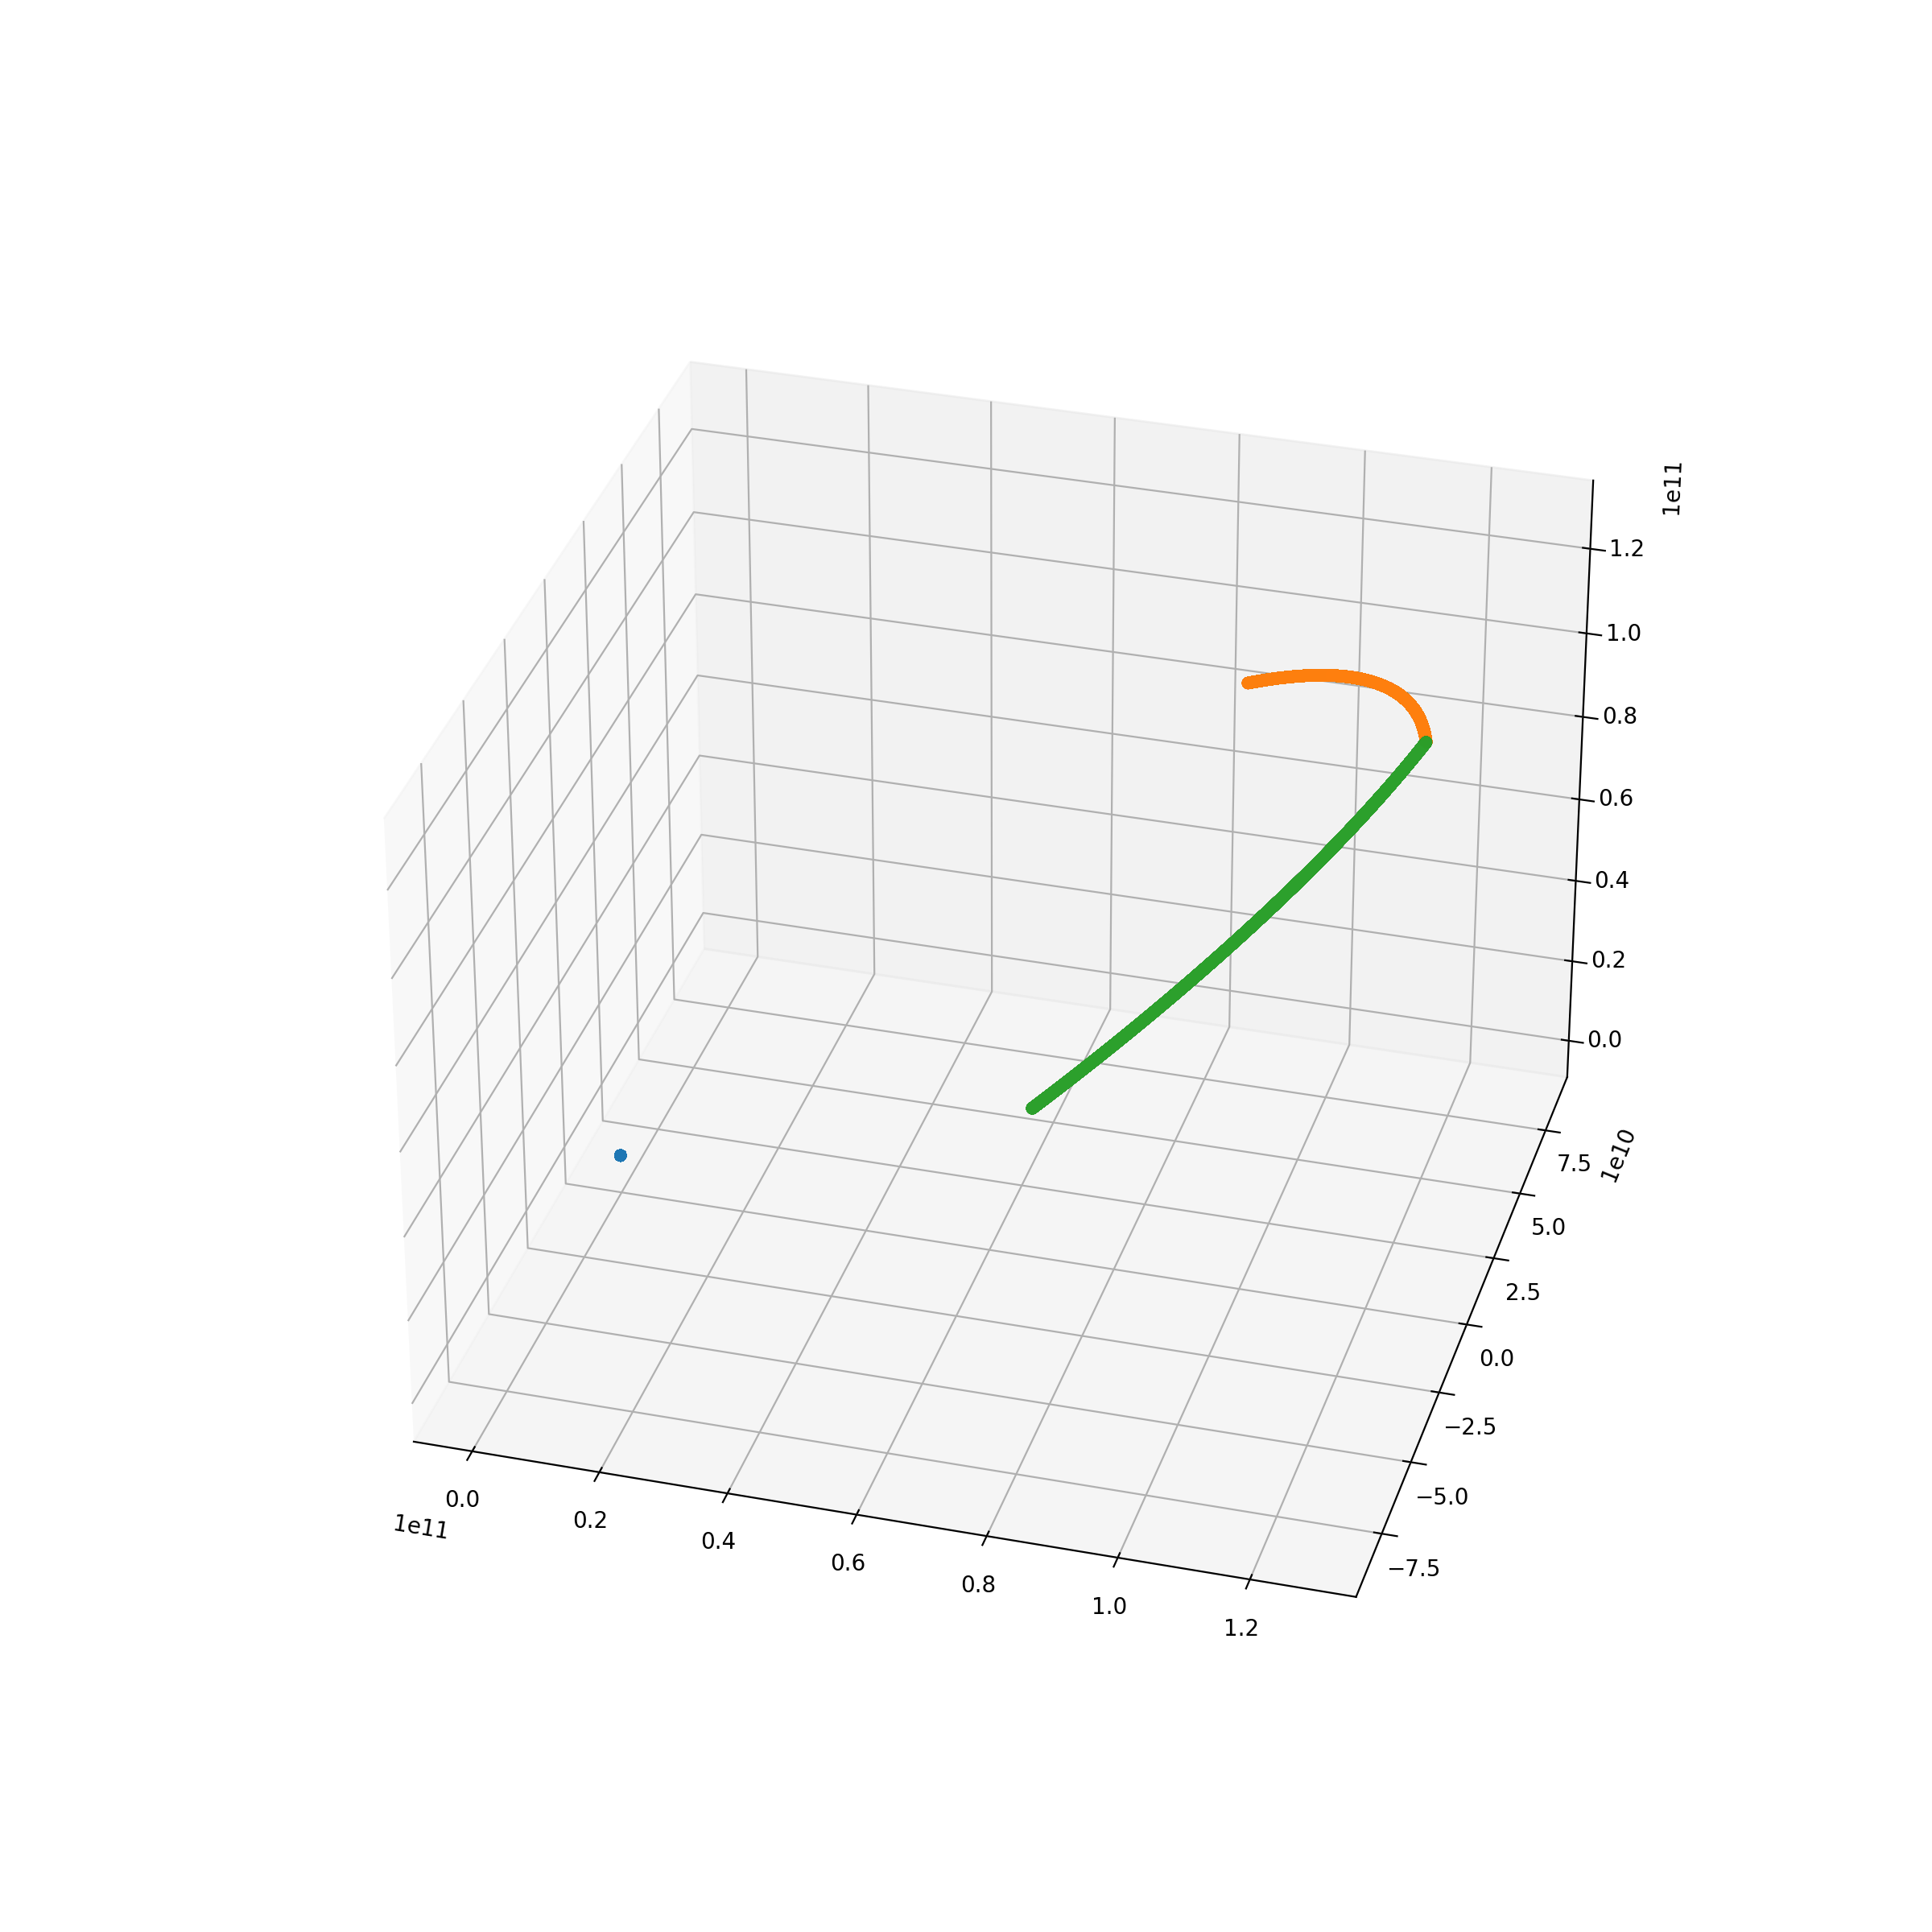

In [17]:
%matplotlib notebook

test_two_fishes3D()

<IPython.core.display.Javascript object>


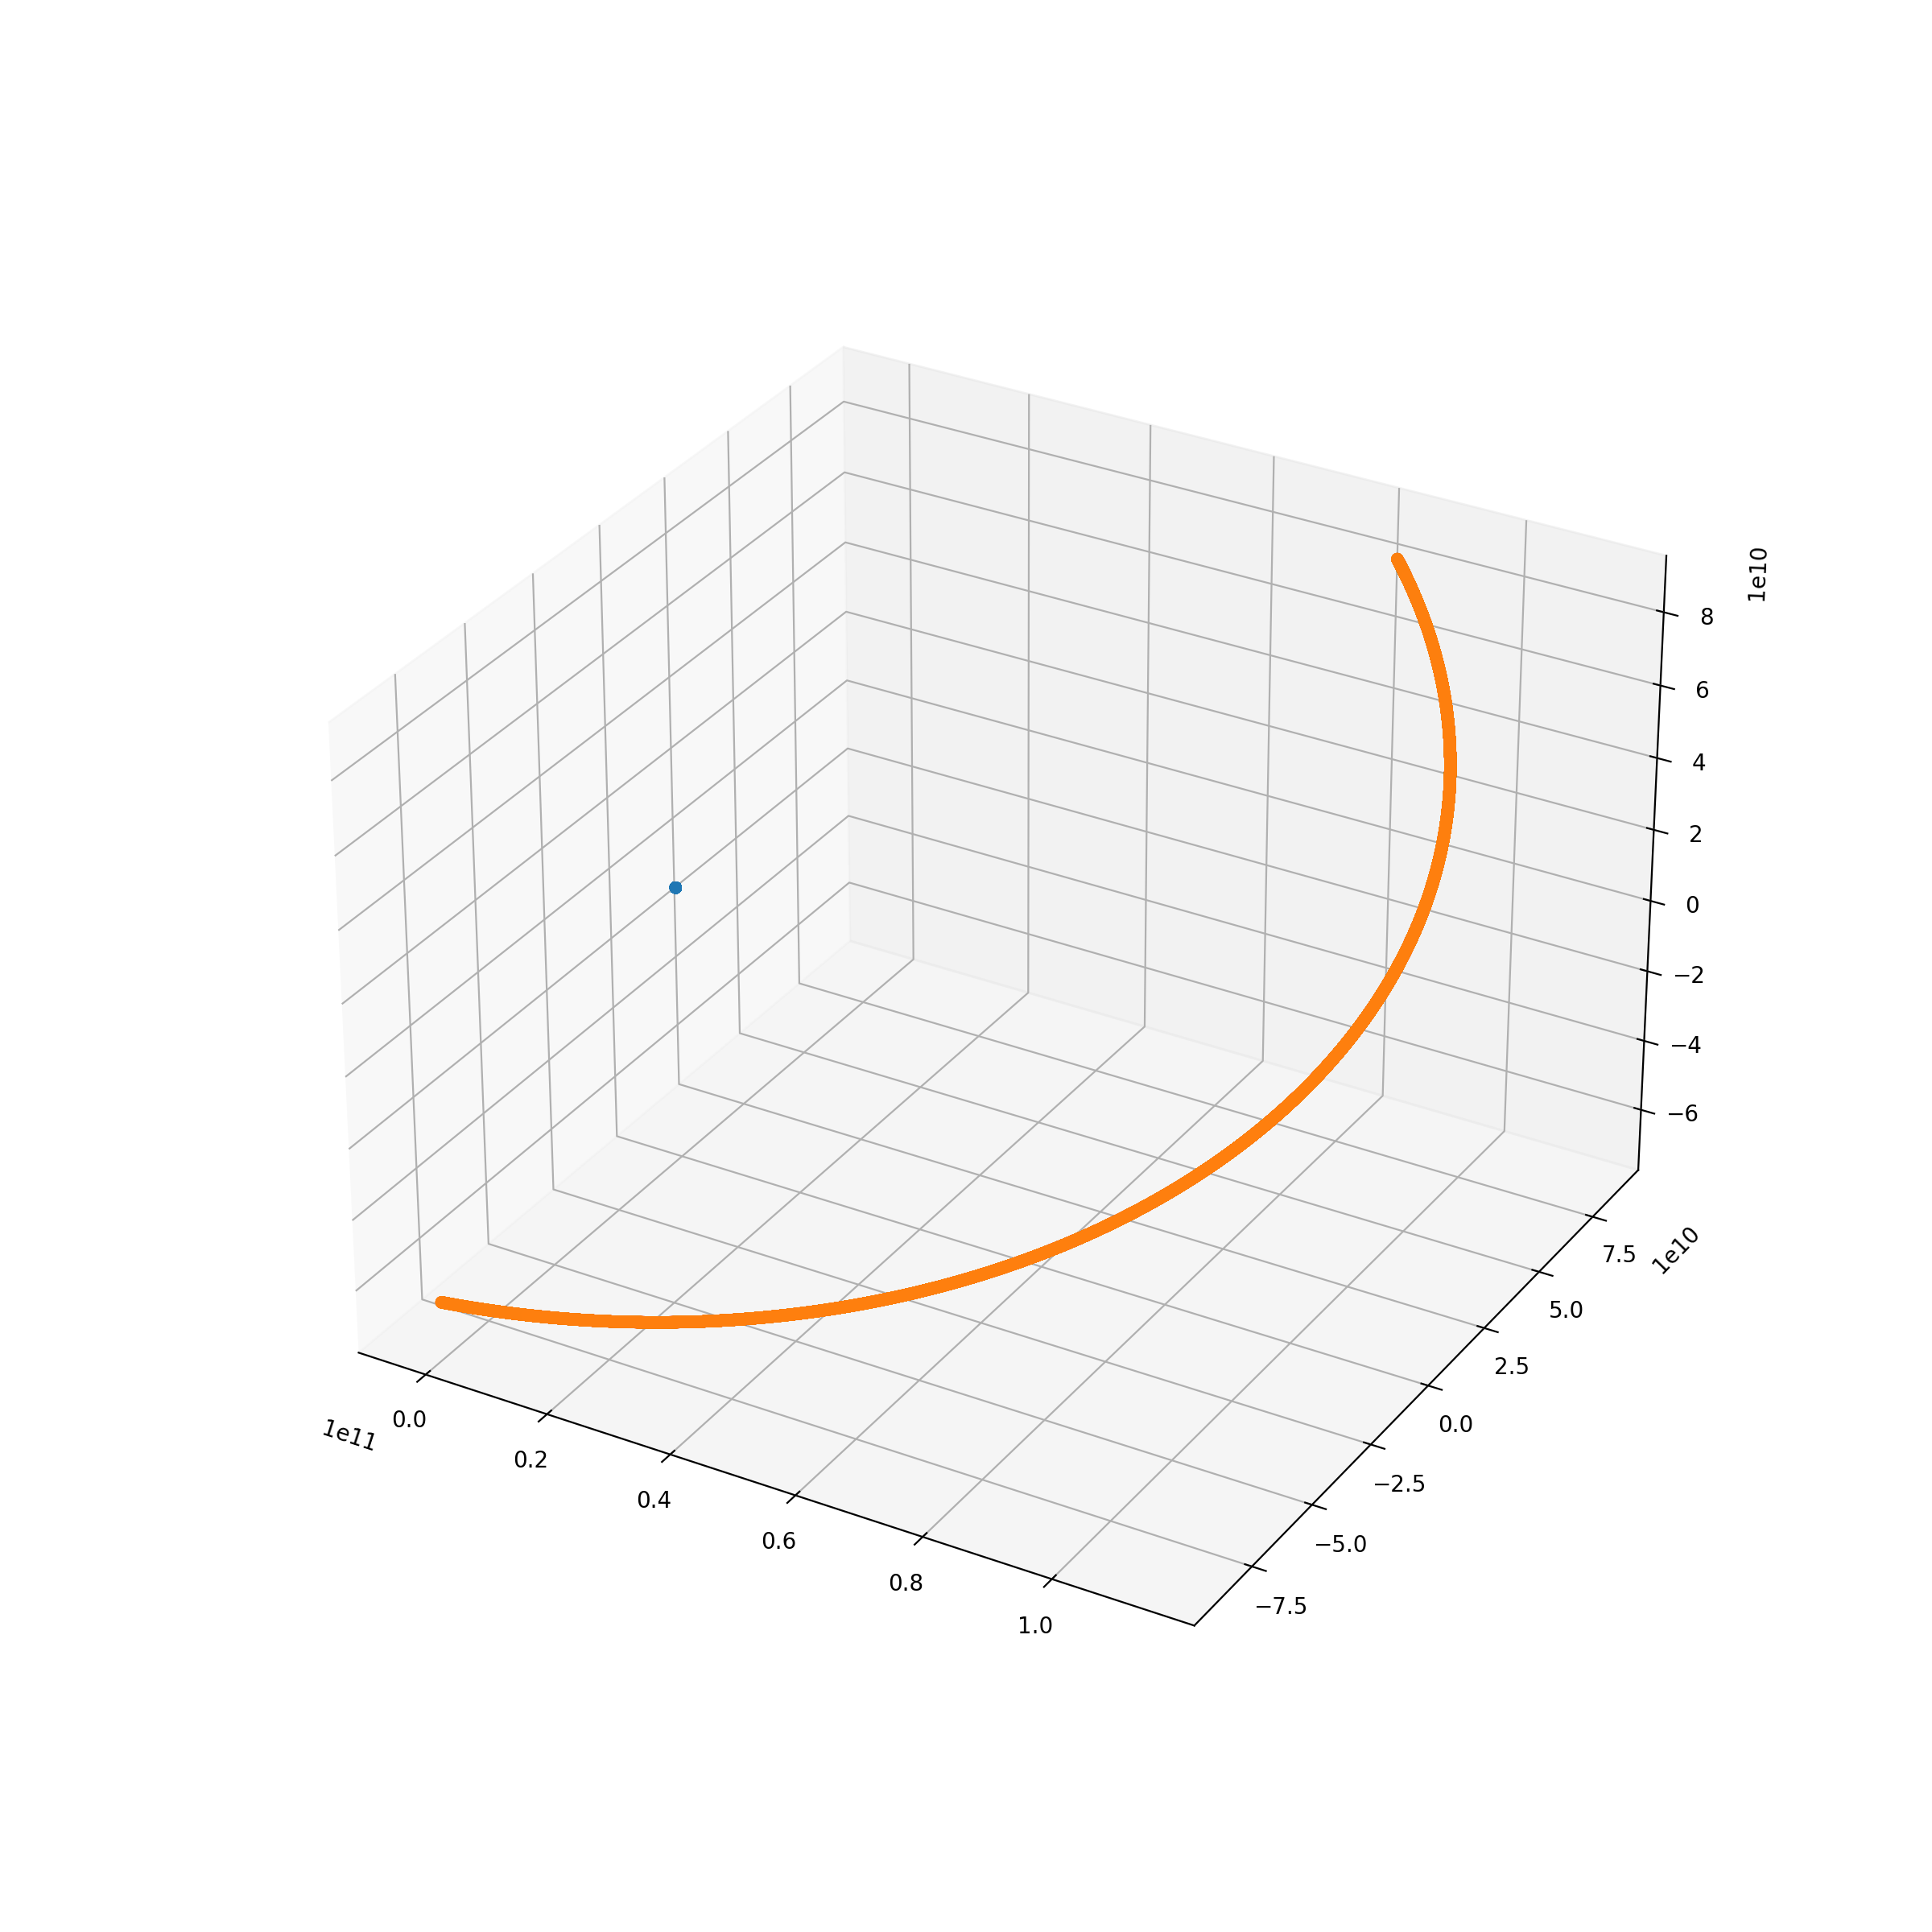

In [16]:
%matplotlib notebook

test_one_fish3D()